# D_a_1 Test affichage de la pointe

L'objectif de la 2ᵉ partie de l'outil de visualisation est de surligner les périodes de pointes qui pourraient être identifiées par HQ comme période où les clients en tarification dynamique doivent effacer leur utilisation.

Comme nous n'avons pas les critères précis d'HQ ou encore une liste de périodes précédemment identifiées, nous ferons l'approximation comme quoi :

> la période de pointe est appelée lorsque le maximum prévu dans la période dépassera un certain seuil, qu'on peut estimer à 32000 MW.

Dans les faits, il est possible que le critère soit plus complexe. Par exemple, s'il y a plusieurs pointes à 31000 MW plusieurs journées en ligne, il est possible que l'appel soit fait. On peut aussi croire que le niveau de l'eau dans les grands barrages, la quantité d'électricité vendue à l'extérieur du Québec ou d'autres facteurs similaires pèsent aussi dans la balance. 

Notons que les 2 périodes sont :  
- 7 jours sur 7 (Crédit hivernal)
- lundi au vendredi (Flex D)
- entre 6 h et 9 h et
- entre 16 h et 20 h
Source : https://www.hydroquebec.com/residentiel/mieux-consommer/economiser-en-periode-de-pointe/tarification-dynamique/

## Objectifs

L'objectif ici est d'identifier les périodes de pointes du matin et du soir où la demande prévue dépasse un certain seuil (32 000 MW).

Une fois identifié, la période est inscrite dans un tableau et le graphique des prévisions est réalisé avec une bande de couleur (surlignage) sur la période. 

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import locale
from rich import print
from datetime import datetime, date, time
from references import *
from src import *
import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

_ = locale.setlocale(locale.LC_ALL, "fr_CA.UTF-8")

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Import et prédiction

Utilisons la fonction déjà faite pour importer et prédire.

Nous conservons seulement la colonne de prédiction. 

In [251]:
df = make_predictions(onlyFuture=True)
df

,MW,Temp,hourofday,quarter,year,dayofyear,dayofmonth,weekofyear,month,dayofweek,season,isWeekend,isHoliday,day_sin,day_cos,year_sin,year_cos,CDD_21,HDD_18,CDD_24,HDD_16,DT_18-21,DT_16-24,DT_18,DT_21,Temp_LAG_t-1h,DT_18-21_LAG_t-1h,DT_16-24_LAG_t-1h,DT_18_LAG_t-1h,DT_21_LAG_t-1h,Temp_LAG_t-2h,DT_18-21_LAG_t-2h,DT_16-24_LAG_t-2h,DT_18_LAG_t-2h,DT_21_LAG_t-2h,Temp_LAG_t-3h,DT_18-21_LAG_t-3h,DT_16-24_LAG_t-3h,DT_18_LAG_t-3h,DT_21_LAG_t-3h,Temp_LAG_t-4h,DT_18-21_LAG_t-4h,DT_16-24_LAG_t-4h,DT_18_LAG_t-4h,DT_21_LAG_t-4h,Temp_LAG_t-6h,DT_18-21_LAG_t-6h,DT_16-24_LAG_t-6h,DT_18_LAG_t-6h,DT_21_LAG_t-6h,Temp_LAG_t-24h,DT_18-21_LAG_t-24h,DT_16-24_LAG_t-24h,DT_18_LAG_t-24h,DT_21_LAG_t-24h,Temp_MOYMOBILE_t-1h,DT_18-21_MOYMOBILE_t-1h,DT_16-24_MOYMOBILE_t-1h,DT_18_MOYMOBILE_t-1h,DT_21_MOYMOBILE_t-1h,Temp_MOYMOBILE_t-2h,DT_18-21_MOYMOBILE_t-2h,DT_16-24_MOYMOBILE_t-2h,DT_18_MOYMOBILE_t-2h,DT_21_MOYMOBILE_t-2h,Temp_MOYMOBILE_t-3h,DT_18-21_MOYMOBILE_t-3h,DT_16-24_MOYMOBILE_t-3h,DT_18_MOYMOBILE_t-3h,DT_21_MOYMOBILE_t-3h,Temp_MOYMOBILE_t-4h,DT_18-21_MOYMOBILE_t-4h,DT_16-24_MOYMOBILE_t-4h,DT_18_MOYMOBILE_t-4h,DT_21_MOYMOBILE_t-4h,Temp_MOYMOBILE_t-6h,DT_18-21_MOYMOBILE_t-6h,DT_16-24_MOYMOBILE_t-6h,DT_18_MOYMOBILE_t-6h,DT_21_MOYMOBILE_t-6h,Temp_MOYMOBILE_t-8h,DT_18-21_MOYMOBILE_t-8h,DT_16-24_MOYMOBILE_t-8h,DT_18_MOYMOBILE_t-8h,DT_21_MOYMOBILE_t-8h,Temp_MOYMOBILE_t-12h,DT_18-21_MOYMOBILE_t-12h,DT_16-24_MOYMOBILE_t-12h,DT_18_MOYMOBILE_t-12h,DT_21_MOYMOBILE_t-12h,Temp_MOYMOBILE_t-16h,DT_18-21_MOYMOBILE_t-16h,DT_16-24_MOYMOBILE_t-16h,DT_18_MOYMOBILE_t-16h,DT_21_MOYMOBILE_t-16h,Temp_MOYMOBILE_t-24h,DT_18-21_MOYMOBILE_t-24h,DT_16-24_MOYMOBILE_t-24h,DT_18_MOYMOBILE_t-24h,DT_21_MOYMOBILE_t-24h,isFuture,isFuture_but_MW_History,pred
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-11 01:00:00,NaN,0.1,1,4,2023,345,11,50,12,0,3,0,0,0.258819,9.659258e-01,-0.354310,0.935128,0.0,17.9,0.0,15.9,17.9,15.9,17.9,20.9,1.1,16.9,14.9,16.9,19.9,1.2,16.8,14.8,16.8,19.8,2.2,15.8,13.8,15.8,18.8,1.8,16.2,14.2,16.2,19.2,3.0,15.0,13.0,15.0,18.0,4.3,13.7,11.7,13.7,16.7,0.1,17.9,15.9,17.9,20.9,0.60,17.40,15.40,17.40,20.40,0.800000,17.200000,15.200000,17.200000,20.200000,1.150,16.850,14.850,16.850,19.850,1.433333,16.566667,14.566667,16.566667,19.566667,1.8000,16.2000,14.2000,16.2000,19.2000,2.308333,15.691667,13.691667,15.691667,18.691667,2.86875,15.13125,13.13125,15.13125,18.13125,3.470833,14.529167,12.529167,14.529167,17.529167,True,True,21457.636719
2023-12-11 02:00:00,NaN,0.0,2,4,2023,345,11,50,12,0,3,0,0,0.500000,8.660254e-01,-0.353639,0.935382,0.0,18.0,0.0,16.0,18.0,16.0,18.0,21.0,0.1,17.9,15.9,17.9,20.9,1.1,16.9,14.9,16.9,19.9,1.2,16.8,14.8,16.8,19.8,2.2,15.8,13.8,15.8,18.8,2.2,15.8,13.8,15.8,18.8,4.6,13.4,11.4,13.4,16.4,0.0,18.0,16.0,18.0,21.0,0.05,17.95,15.95,17.95,20.95,0.400000,17.600000,15.600000,17.600000,20.600000,0.600,17.400,15.400,17.400,20.400,1.066667,16.933333,14.933333,16.933333,19.933333,1.4500,16.5500,14.5500,16.5500,19.5500,2.008333,15.991667,13.991667,15.991667,18.991667,2.54375,15.45625,13.45625,15.45625,18.45625,3.279167,14.720833,12.720833,14.720833,17.720833,True,True,21474.285156
2023-12-11 03:00:00,NaN,-0.4,3,4,2023,345,11,50,12,0,3,0,0,0.707107,7.071068e-01,-0.352969,0.935635,0.0,18.4,0.0,16.4,18.4,16.4,18.4,21.4,0.0,18.0,16.0,18.0,21.0,0.1,17.9,15.9,17.9,20.9,1.1,16.9,14.9,16.9,19.9,1.2,16.8,14.8,16.8,19.8,1.8,16.2,14.2,16.2,19.2,4.2,13.8,11.8,13.8,16.8,-0.4,18.4,16.4,18.4,21.4,-0.20,18.20,16.20,18.20,21.20,-0.100000,18.100000,16.100000,18.100000,21.100000,0.200,17.800,15.800,17.800,20.800,0.700000,17.300000,15.300000,17.300000,20.300000,1.0250,16.9750,14.9750,16.9750,19.9750,1.700000,16.300000,14.300000,16.300000,19.300000,2.23125,15.76875,13.76875,15.76875,18.76875,3.087500,14.912500,12.912500,14.912500,17.912500,True,True,21985.496094
2023-12-11 04:00:00,NaN,-0.6,4,4,2023,345,11,50,12,0,3,0,0,0.866025,5.000000e-01,-0.352298,0.935888,0.0,18.6,0.0,16.6,18.6,16.6,18.6,21.6,-0.4,18.4,16.

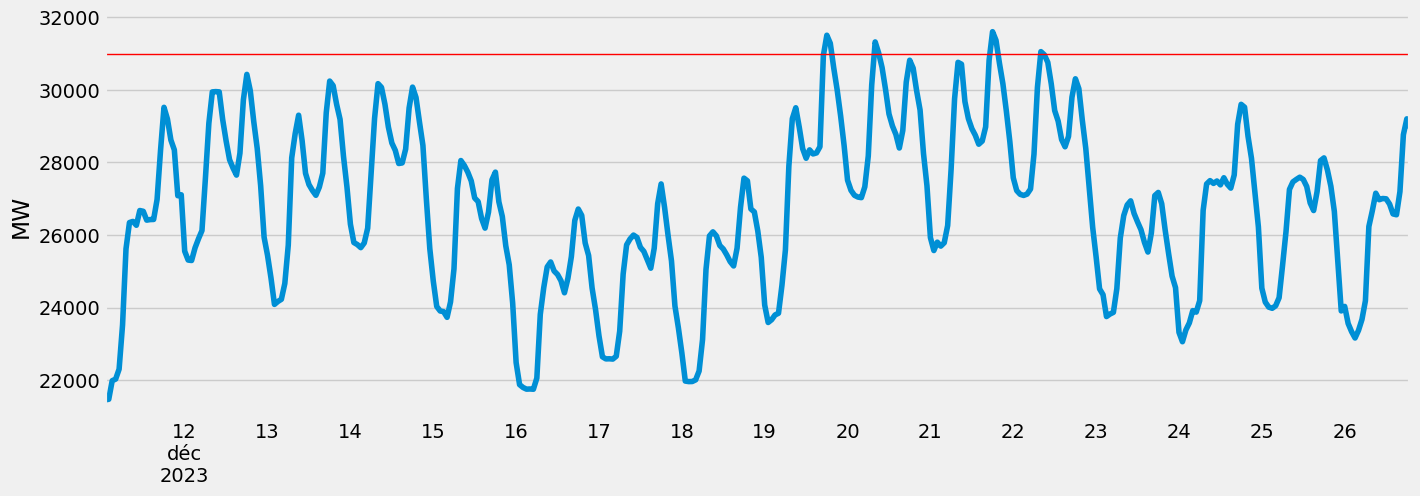

In [49]:
# Valeur utilisée pour décider si période de pointe
pointeBascule = 31_000

# Visualisation
ax = df.pred.plot(
    figsize=(15, 5),
    ylabel="MW",
    xlabel="",
)
ax.axhline(
    y=pointeBascule,
    color=colors_pal[0],
    linewidth=1,
)
ax.legend().remove()
plt.show()

Nous pouvons voir dans ce graphique que si nous utilisons la valeur de bascule de la pointe à 31 000 MW, nous aurions 4 évènements de pointes :
- le 19 PM
- le 20 AM
- le 21 PM
- le 22 AM

Voyons voir comment nous pouvons déterminer cela dans le dataframe. 

In [252]:
df["date"] = df.index.date
df = df[["date", "hourofday", "pred", "Temp"]]

In [82]:
heures_AM = [6, 7, 8, 9]
heures_PM = [16, 17, 18, 19, 20]

In [253]:
df

,date,hourofday,pred,Temp
date,,,,
2023-12-11 01:00:00,2023-12-11,1,21457.636719,0.1
2023-12-11 02:00:00,2023-12-11,2,21474.285156,0.0
2023-12-11 03:00:00,2023-12-11,3,21985.496094,-0.4
2023-12-11 04:00:00,2023-12-11,4,22030.175781,-0.6
2023-12-11 05:00:00,2023-12-11,5,22303.890625,-0.7
...,...,...,...,...
2023-12-26 15:00:00,2023-12-26,15,26557.255859,-4.3
2023-12-26 16:00:00,2023-12-26,16,27194.265625,-4.4
2023-12-26 17:00:00,2023-12-26,17,28763.978516,-4.5


In [254]:
pointeBascule = 31000

df["isHeureAM"] = df.hourofday.apply(lambda x: x in heures_AM)
df["isHeurePM"] = df.hourofday.apply(lambda x: x in heures_PM)
df["isSupBascule"] = df.pred.apply(lambda x: x >= pointeBascule)

jours_pointe_matin = pd.unique(df.query("isHeureAM and isSupBascule")["date"]).tolist()
jours_pointe_soir = pd.unique(df.query("isHeurePM and isSupBascule")["date"]).tolist()

if jours_pointe_matin:
    print("Dates de pointe AM :")
    [print(p) for p in jours_pointe_matin]
else:
    print("Aucune pointe matinale à venir")

if jours_pointe_soir:
    print("Dates de pointe PM :")
    [print(p) for p in jours_pointe_soir]
else:
    print("Aucune pointe de fin de journée à venir")

Dates de pointe AM :

2023-12-20

2023-12-22

Dates de pointe PM :

2023-12-19

2023-12-21

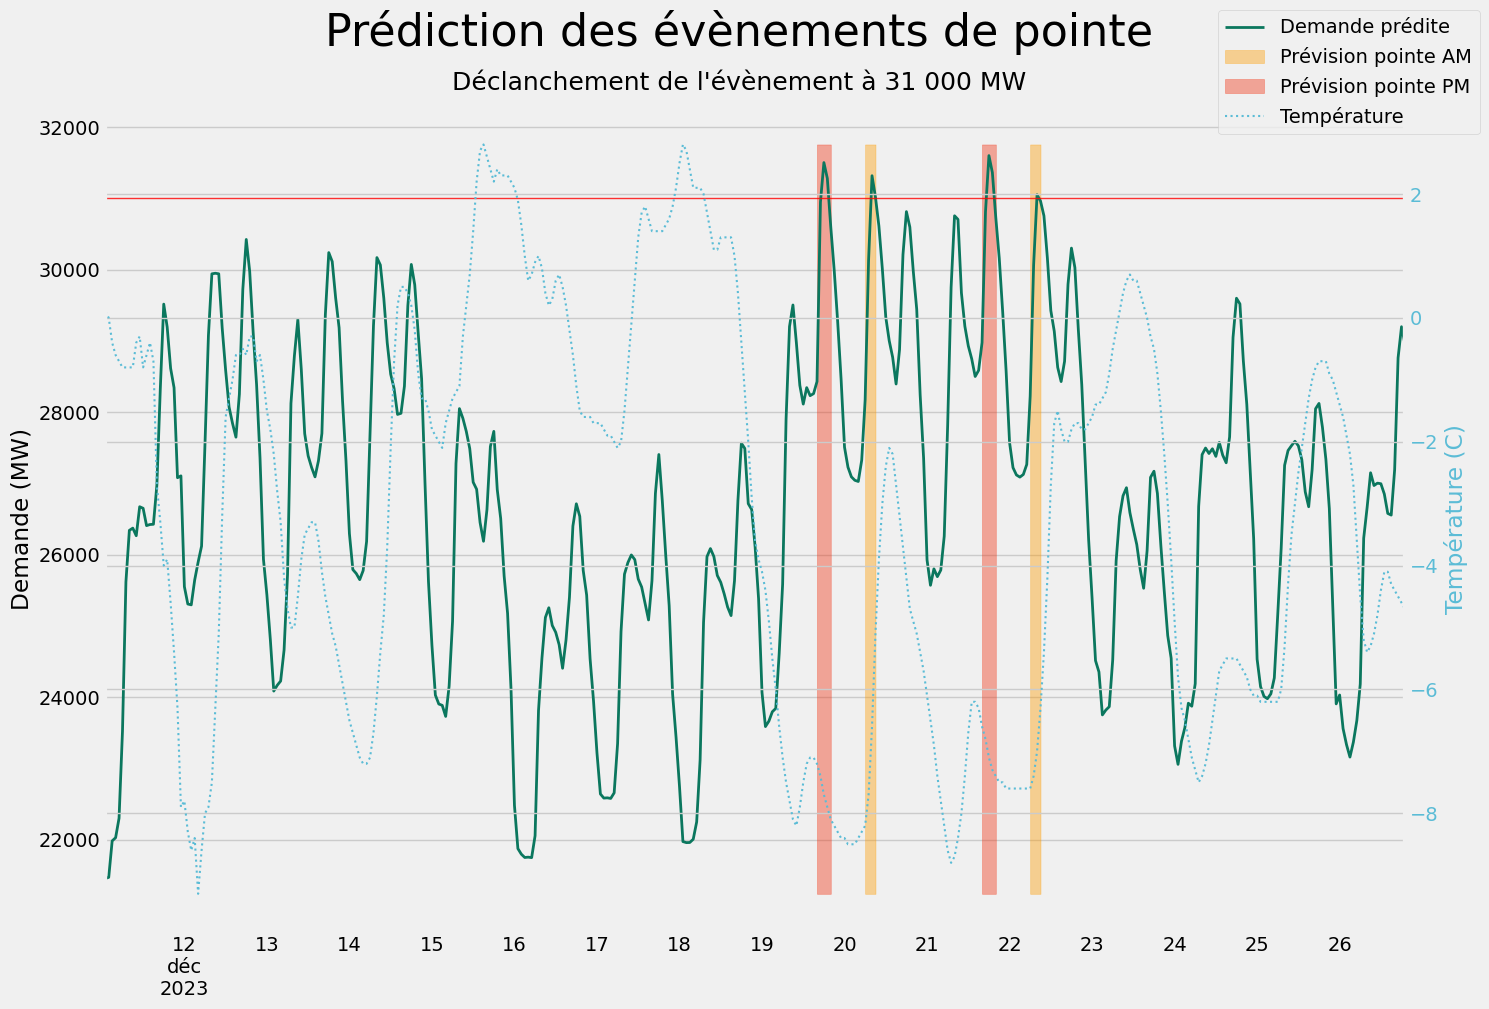

In [257]:
# Visualisation

withTemperature = True

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

ax = df.pred.plot(
    ylabel="Demande (MW)",
    xlabel="",
    label="Demande prédite",
    lw=2,
    color=col_demande_predite,
)
ax.axhline(
    y=pointeBascule,
    color=colors_pal[0],
    linewidth=1,
    alpha=0.8,
)

show_legend = True
for d in jours_pointe_matin:
    ax.fill_betweenx(
        y=range(int(min(df.pred) * 0.99), int(max(df.pred) * 1.005)),
        x1=datetime.combine(d, time(hour=6)),
        x2=datetime.combine(d, time(hour=9)),
        color=colors_pal[11],
        alpha=0.4,
        label="Prévision pointe AM" if show_legend else "",
    )
    show_legend = False

show_legend = True
for d in jours_pointe_soir:
    ax.fill_betweenx(
        y=range(int(min(df.pred) * 0.99), int(max(df.pred) * 1.005)),
        x1=datetime.combine(d, time(hour=16)),
        x2=datetime.combine(d, time(hour=20)),
        color=colors_pal[10],
        alpha=0.4,
        label="Prévision pointe PM" if show_legend else "",
    )
    show_legend = False

if withTemperature:
    ax2 = ax.twinx()

    color = col_temperature
    ax2.set_ylabel("Température (C)", color=color)

    df["Temp"].plot(
        ax=ax2,
        ms=1,
        lw=1.5,
        ls="dotted",
        label="Température",
        xlabel="",
        color=color,
    )

    ax2.tick_params(axis="y", labelcolor=color)

fig.suptitle(
    f"Prédiction des évènements de pointe",
    ha="center",
    y=1.01,
    fontsize=32,
)

pb = "{:,}".format(pointeBascule).replace(",", " ")

fig.text(
    x=0.5,
    y=0.93,
    s=f"Déclanchement de l'évènement à {pb} MW",
    fontsize=18,
    ha="center",
)

fig.legend()
plt.tight_layout()
plt.show()